<a href="https://colab.research.google.com/github/KunAn89/Modeling_Risk/blob/main/Modeling_Market_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

VaR
Value at Risk

Colab Running Information

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


Package

In [3]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 5.6 MB/s eta 0:00:00


In [65]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gspread
import matplotlib.cm as cm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Input, Dense, LSTM, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Reshape

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import t
from arch import arch_model

from google.colab import auth
from google.auth import default

Data Reading

In [5]:
#Setup for Google Sheets API
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

def get_sheet_data(spreadsheet_name, worksheet_index=0):
    spreadsheet = gc.open(spreadsheet_name)
    worksheet = spreadsheet.get_worksheet(worksheet_index)
    data = worksheet.get_all_values()
    df = pd.DataFrame(data)
    df.columns = df.iloc[0]
    df = df.drop(0)
    df['Date'] = df['Date'].str.split().str[0]
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y').dt.date
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    return df


sheet_names = ["META", "MSFT", "NFLX"]

dataframes = [get_sheet_data(name) for name in sheet_names]

combined_df = pd.concat(dataframes, ignore_index=True)

for df in dataframes:
    print(df.head())

0        Date    Open    High     Low   Close    Volume
1  2022-01-03   338.3  341.08  337.19  338.54  14562849
2  2022-01-04  339.95  343.09  331.87  336.53  15997974
3  2022-01-05  333.02  335.76  323.84  324.17  20564521
4  2022-01-06  322.82  339.17  322.72  332.46  27962809
5  2022-01-07  332.74     337  328.88  331.79  14722020
0        Date    Open    High     Low   Close    Volume
1  2022-01-03  335.35     338  329.78  334.75  28918013
2  2022-01-04  334.83   335.2  326.12  329.01  32674306
3  2022-01-05  325.86  326.07  315.98  316.38  40054327
4  2022-01-06  313.15   318.7  311.49  313.88  39646148
5  2022-01-07  314.15   316.5  310.09  314.04  32720018
0        Date    Open    High     Low   Close   Volume
1  2022-01-03  605.61  609.99  590.56  597.37  3068808
2  2022-01-04  599.91  600.41   581.6  591.15  4393135
3  2022-01-05     592  592.84  566.88  567.52  4148749
4  2022-01-06  554.34  563.36  542.01  553.29  5711795
5  2022-01-07  549.46  553.43  538.22  541.06  338287

Test Data

In [6]:
sheet_names_test = ["Test Data"]

dataframes_test = [get_sheet_data(name) for name in sheet_names_test]

combined_df = pd.concat(dataframes_test, ignore_index=True)

for df in dataframes_test:
    print(df.head())

0        Date Open   High     Low  Close Volume
1  2022-01-04  616    622  610.05  614.0  10779
2  2022-01-05  614  615.6  611.52  614.0   5924
3  2022-01-06  614  615.6     610  614.0   7015
4  2022-01-07  625  615.6     611  612.0  25109
5  2022-01-10  625    612     605  612.0   7741


Visulization

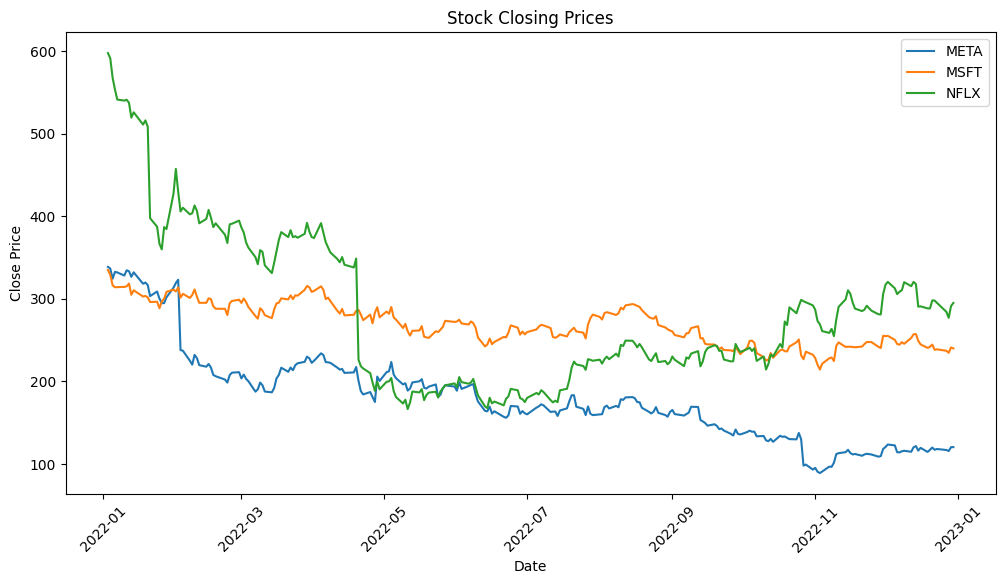

In [7]:
dataframes_forSeen = {name: get_sheet_data(name) for name in sheet_names}
plt.figure(figsize=(12, 6))
for name, df in dataframes_forSeen.items():
    plt.plot(df['Date'], df['Close'], label=name)

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Closing Prices')
plt.legend()
plt.xticks(rotation=45)
plt.show()

Data Set Reinforcement

In [34]:
def bootstrap_data(df, n_bootstraps=1):
    bootstrap_samples = []
    for _ in range(n_bootstraps):
        sample = df.sample(n=len(df), replace=True)  # Allow Repeat
        bootstrap_samples.append(sample)
    return bootstrap_samples

In [35]:
# Assuming 'dataframes' is your list of original dataframes
bootstraped_dataframes = [bootstrap_data(df) for df in dataframes]

# Iterating through each bootstrap sample for each original dataframe
for i, bootstrapped_dfs in enumerate(bootstraped_dataframes):
    print(f"Original DataFrame {i}:")
    for j, df_sample in enumerate(bootstrapped_dfs):
        print(f"Bootstrap Sample {j + 1} Head:")
        print(df_sample.head())
        print()  # Just for a blank line between samples

Original DataFrame 0:
Bootstrap Sample 1 Head:
0          Date    Open    High     Low   Close    Volume
250  2022-12-29   116.4  121.03  115.77  120.26  22366192
226  2022-11-23  111.72  112.67  110.73  112.24  21343083
55   2022-03-22  211.37  219.46  210.18  216.65  31998799
156  2022-08-16  179.44  180.99  177.04  179.47  21156710
100  2022-05-25   180.4  185.45  179.32  183.83  28030194

Original DataFrame 1:
Bootstrap Sample 1 Head:
0          Date    Open    High     Low   Close    Volume
102  2022-05-27  268.48  273.34  267.56  273.24  26910806
68   2022-04-08  300.44  301.12  296.28  296.97  24361917
193  2022-10-07   240.9  241.32  233.17  234.24  37769602
121  2022-06-27  268.21   268.3  263.28  264.89  24615114
193  2022-10-07   240.9  241.32  233.17  234.24  37769602

Original DataFrame 2:
Bootstrap Sample 1 Head:
0          Date    Open    High     Low   Close    Volume
172  2022-09-08  224.16  228.74   221.3  227.44   6737436
233  2022-12-05  316.46  322.77  310.92  312.

In [10]:
def prepare_data_for_lstm(df, feature_columns, target_column, n_steps):
    """
    Prepares data for LSTM.

    :param df: Input DataFrame.
    :param feature_columns: List of column names to be used as features.
    :param target_column: Name of the target column.
    :param n_steps: Number of time steps to look back for the LSTM.
    :return: Returns input and output data for the LSTM.
    """

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[feature_columns])

    X, y = [], []

    # Create sequences
    for i in range(n_steps, len(df)):
        X.append(scaled_data[i-n_steps:i, :])
        y.append(scaled_data[i, df.columns.get_loc(target_column)])

    # Convert to arrays and reshape for LSTM
    X, y = np.array(X), np.array(y)

    # LSTM expects input shape of [samples, time steps, features]
    X = np.reshape(X, (X.shape[0], X.shape[1], len(feature_columns)))

    return X, y, scaler

In [11]:
n_steps = 5  # Use data from the past 5 time points to predict the next time point

In [12]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        LSTM(50),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [25]:
lstm_models = []
predictions = []

for df in dataframes:
    X, y, scaler = prepare_data_for_lstm(df=dataframes[0], feature_columns=['Open', 'High', 'Low', 'Close', 'Volume'], target_column='Close', n_steps=n_steps)
    model = build_lstm_model(X.shape[1:])
    model.fit(X, y, epochs=10, batch_size=32)
    lstm_models.append(model)
    predictions.append(model.predict(X))

Epoch 1/10
8/8 [==============================] - 3s 5ms/step - loss: 0.0166
Epoch 2/10
8/8 [==============================] - 0s 5ms/step - loss: 0.0133
Epoch 3/10
8/8 [==============================] - 0s 9ms/step - loss: 0.0115
Epoch 4/10
8/8 [==============================] - 0s 11ms/step - loss: 0.0104
Epoch 5/10
8/8 [==============================] - 0s 5ms/step - loss: 0.0099
Epoch 6/10
8/8 [==============================] - 0s 5ms/step - loss: 0.0099
Epoch 7/10
8/8 [==============================] - 0s 5ms/step - loss: 0.0100
Epoch 8/10
8/8 [==============================] - 0s 6ms/step - loss: 0.0093
Epoch 9/10
8/8 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 10/10
8/8 [==============================] - 1s 4ms/step
Epoch 1/10
8/8 [==============================] - 4s 7ms/step - loss: 0.0135
Epoch 2/10
8/8 [==============================] - 0s 7ms/step - loss: 0.0113
Epoch 3/10
8/8 [==============================] - 0s 8ms/step - loss: 0.0104
Epoch 4/10
8

In [31]:
print(predictions)

[array([[0.08314811],
       [0.08610796],
       [0.08652437],
       [0.08350069],
       [0.07867971],
       [0.07883433],
       [0.07697655],
       [0.07946438],
       [0.0814388 ],
       [0.08533251],
       [0.09295392],
       [0.09537348],
       [0.09884372],
       [0.10131772],
       [0.09742186],
       [0.09055648],
       [0.08783937],
       [0.09397768],
       [0.14523049],
       [0.18983117],
       [0.23002072],
       [0.26829046],
       [0.28133133],
       [0.21984558],
       [0.20121057],
       [0.17680961],
       [0.15035507],
       [0.13086121],
       [0.12718827],
       [0.12343998],
       [0.12380413],
       [0.1238915 ],
       [0.12497626],
       [0.12607552],
       [0.12560147],
       [0.12078549],
       [0.11270545],
       [0.1032536 ],
       [0.10029279],
       [0.10154444],
       [0.10629124],
       [0.10914678],
       [0.10940897],
       [0.10890359],
       [0.10470115],
       [0.10211624],
       [0.10490216],
       [0.10

GANS

In [66]:
def build_generator(seq_length, latent_dim, n_features=5):
    input_noise = Input(shape=(latent_dim,))
    x = Dense(128)(input_noise)
    x = LeakyReLU(alpha=0.01)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(seq_length * n_features)(x)  # Adjust the number of units
    x = Reshape((seq_length, n_features))(x)  # Reshape to match the discriminator's input
    return Model(input_noise, x)

In [67]:
def build_gan(generator, discriminator):
    z = Input(shape=(latent_dim,))
    fake_seq = generator(z)
    discriminator.trainable = False
    validity = discriminator(fake_seq)
    return Model(z, validity)

In [68]:
def build_discriminator(seq_length, n_features=5):
    seq = Input(shape=(seq_length, n_features))
    x = LSTM(64, return_sequences=True)(seq)
    x = LSTM(64)(x)
    x = Dense(1, activation='sigmoid')(x)
    return Model(seq, x)

In [69]:
# Function to preprocess and create sequences
def preprocess_and_create_sequences(df, selected_columns, seq_length):
    data = df[selected_columns]

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Create sequences
    def create_sequences(data, seq_length):
        xs, ys = [], []
        for i in range(len(data) - seq_length):
            x = data[i:(i + seq_length)]
            y = data[i + seq_length]
            xs.append(x)
            ys.append(y)
        return np.array(xs), np.array(ys)

    X, y = create_sequences(scaled_data, seq_length)
    return X, y, scaler

# Preprocess each DataFrame and create sequences
latent_dim = 32
seq_length = 60
processed_data = [preprocess_and_create_sequences(df, ['Open', 'High', 'Low', 'Close', 'Volume'], seq_length) for df in dataframes]

In [70]:
generator = build_generator(seq_length, latent_dim, n_features=5)  # Make sure to match n_features
discriminator = build_discriminator(seq_length, n_features=5)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [71]:
def train_gan(generator, discriminator, gan, processed_data, epochs, batch_size, latent_dim):
    for data_tuple in processed_data:
        X, y, _ = data_tuple  # Assuming each tuple is (X, y, scaler)
        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            # Randomly select real sequences
            idx = np.random.randint(0, X.shape[0], batch_size)
            real_seqs = X[idx]

            # Generate fake sequences
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            fake_seqs = generator.predict(noise)

            # Train discriminator
            d_loss_real = discriminator.train_on_batch(real_seqs, real)
            d_loss_fake = discriminator.train_on_batch(fake_seqs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train generator
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            g_loss = gan.train_on_batch(noise, real)

            # Print progress
            if epoch % 100 == 0:
                print(f"Epoch {epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}] [G loss: {g_loss}]")

In [73]:
train_gan(generator, discriminator, gan, processed_data, epochs=3, batch_size=32, latent_dim=latent_dim)

1/1 [==============================] - 0s 19ms/step
Epoch 0 [D loss: 0.016472199000418186, acc.: 100.0] [G loss: 4.436320781707764]
1/1 [==============================] - 0s 16ms/step
Epoch 0 [D loss: 0.9342595040798187, acc.: 75.0] [G loss: 3.243274688720703]
1/1 [==============================] - 0s 19ms/step
Epoch 0 [D loss: 2.104492664337158, acc.: 43.75] [G loss: 3.524397373199463]
1/1 [==============================] - 0s 14ms/step


Stat Method

In [74]:
def calculate_var(df, confidence_level=95):
    # Convert columns to numeric (excluding Date)
    for col in df.columns:
        if col != 'Date':
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Calculate daily returns
    df['Return'] = df['Close'].pct_change()

    # Calculate VaR at the specified confidence level
    var = np.percentile(df['Return'].dropna(), 100 - confidence_level)
    return var

In [75]:
# Calculating VaR for each stock
for name, df in zip(sheet_names, dataframes):
    var = calculate_var(df)
    print(f"VaR at 95% confidence level for {name}: {var*100:.2f}%")

VaR at 95% confidence level for META: -5.87%
VaR at 95% confidence level for MSFT: -3.85%
VaR at 95% confidence level for NFLX: -5.53%


Historical Historical Maximum Loss

In [76]:
# Function to calculate VaR by finding the greatest loss
def calculate_VaR_simple_loss(df):
    # Convert columns to numeric (excluding Date)
    for col in df.columns:
        if col != 'Date':
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Calculate daily returns
    df['Return'] = df['Close'].pct_change()

    # Find the greatest loss (minimum return)
    greatest_loss = df['Return'].min()
    return greatest_loss

In [77]:
# Calculating VaR for each stock by identifying the greatest loss
for name, df in zip(sheet_names, dataframes):
    var = calculate_VaR_simple_loss(df)
    print(f"VaR (greatest loss) for {name}: {var*100:.2f}%")

VaR (greatest loss) for META: -26.39%
VaR (greatest loss) for MSFT: -7.72%
VaR (greatest loss) for NFLX: -35.12%


Time Decay Factor EWMA

In [78]:
def calculate_VaR_with_time_decay(df, decay_factor=1):
    # Convert columns to numeric (excluding Date)
    for col in df.columns:
        if col != 'Date':
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Calculate daily returns
    df['Return'] = df['Close'].pct_change()

    # Apply exponential weighting
    weights = np.array([decay_factor**i for i in range(len(df))])[::-1]
    weighted_returns = df['Return'] * weights
    weighted_returns /= weights.sum()

    # Find the greatest loss (minimum return) in weighted returns
    greatest_loss = weighted_returns.min()
    return greatest_loss

In [79]:
# Calculating VaR for each stock by identifying the greatest loss
for name, df in zip(sheet_names, dataframes):
    var = calculate_VaR_with_time_decay(df)
    print(f"VaR (greatest loss) for {name}: {var*100:.2f}%")

VaR (greatest loss) for META: -0.11%
VaR (greatest loss) for MSFT: -0.03%
VaR (greatest loss) for NFLX: -0.14%


In [80]:
def calculate_VaR_with_time_decay_amend(df, decay_factor=1):
    # Convert columns to numeric (excluding Date)
    for col in df.columns:
        if col != 'Date':
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Calculate daily returns
    df['Return'] = df['Close'].pct_change()

    # Handle NaN values in returns
    df.dropna(subset=['Return'], inplace=True)

    # When decay_factor is 1, use unweighted returns directly
    if decay_factor == 1:
        greatest_loss = df['Return'].min()
    else:
        # Apply exponential weighting
        weights = np.array([decay_factor**i for i in range(len(df))])[::-1]
        weighted_returns = df['Return'] * weights
        weighted_returns /= weights.sum()

        # Find the greatest loss in weighted returns
        greatest_loss = weighted_returns.min()

    return greatest_loss


In [81]:
# Calculating VaR for each stock by identifying the greatest loss
for name, df in zip(sheet_names, dataframes):
    var = calculate_VaR_with_time_decay_amend(df)
    print(f"VaR (greatest loss) for {name}: {var*100:.2f}%")

VaR (greatest loss) for META: -26.39%
VaR (greatest loss) for MSFT: -7.72%
VaR (greatest loss) for NFLX: -35.12%


CVaR  Expected Shortfall (ES) Tail VaR

In [82]:
def calculate_CVaR_with_time_decay(df, decay_factor=1, confidence_level=0.95):
    # Convert columns to numeric (excluding Date)
    for col in df.columns:
        if col != 'Date':
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Calculate daily returns
    df['Return'] = df['Close'].pct_change()

    # Apply exponential weighting
    weights = np.array([decay_factor**i for i in range(len(df))])[::-1]
    weighted_returns = df['Return'] * weights
    weighted_returns /= weights.sum()

    # Find the VaR (Value at Risk)
    VaR_threshold = np.percentile(weighted_returns.dropna(), (1 - confidence_level) * 100)

    # Calculate CVaR (Conditional Value at Risk)
    # Only consider the returns that are less than the VaR threshold
    tail_losses = weighted_returns[weighted_returns < VaR_threshold]
    CVaR = tail_losses.mean()  # Conditional VaR is the mean of the losses beyond the VaR threshold

    return CVaR

In [83]:
# Calculating CVaR for each stock by identifying the conditional mean loss beyond the VaR threshold
for name, df in zip(sheet_names, dataframes):
    cvar = calculate_CVaR_with_time_decay(df)
    print(f"CVaR (conditional mean loss) for {name}: {cvar*100:.2f}%")

CVaR (conditional mean loss) for META: -0.04%
CVaR (conditional mean loss) for MSFT: -0.02%
CVaR (conditional mean loss) for NFLX: -0.04%


Monte Carlo

Individual Stock

In [84]:
def calculate_stock_returns(initial_value, final_value, days=365):
    """
    Calculate the annual and daily returns of a stock.

    :param initial_value: The initial value of the stock.
    :param final_value: The final value of the stock after a period.
    :param days: The number of days over which the final value is measured. Default is 365 for one year.
    :return: A tuple containing the annual return and daily return as percentages.
    """
    # Calculate annual return
    annual_return = ((final_value - initial_value) / initial_value) * 100

    # Calculate daily return based on the number of days
    daily_return = ((final_value / initial_value) ** (1/days) - 1) * 100

    return annual_return, daily_return

Cal return

In [85]:
for name, df in zip(sheet_names, dataframes):
    if not df.empty:

        df['Date'] = pd.to_datetime(df['Date'])
        df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

        initial_value = df['Close'].iloc[0]
        final_value = df['Close'].iloc[-1]

        days = (df['Date'].iloc[-1] - df['Date'].iloc[0]).days

        annual_return, daily_return = calculate_stock_returns(initial_value, final_value, days)

        print(name, f"Annual Return: {annual_return:.2f}%, Daily Return: {daily_return:.4f}%")

META Annual Return: -64.24%, Daily Return: -0.2852%
MSFT Annual Return: -27.11%, Daily Return: -0.0878%
NFLX Annual Return: -50.12%, Daily Return: -0.1930%


Normal Dis

In [94]:
def calculate_VaR_MonteCarlo_Normal(df, days=1, iterations=10000, confidence_level=0.95, plot=False):
    # Calculate daily returns
    returns = df['Close'].pct_change().dropna()

    # Fit a GARCH model to estimate volatility
    garch = arch_model(returns, vol='Garch', p=1, q=1)
    model = garch.fit(disp='off')
    forecast = model.forecast(horizon=days)
    vol = np.sqrt(forecast.variance.iloc[-1])

    # Calculate mean return
    mean_return = returns.mean()
    # Simulate returns using the normal distribution
    simulated_returns = np.random.normal(mean_return, vol, (iterations, days))
    # Calculate simulated price changes
    simulated_price_changes = np.exp(simulated_returns) - 1

    # Calculate VaR
    VaR = np.percentile(simulated_price_changes, (1 - confidence_level) * 100)

    if plot:
        plt.figure(figsize=(10, 6))
        plt.hist(simulated_price_changes, bins=50, alpha=0.7, color='red')
        plt.axvline(x=VaR, color='red', linestyle='--', label=f"VaR at {confidence_level*100}%: {VaR*100:.2f}%")
        plt.title(f"Simulated Price Changes Distribution\nVaR (at {confidence_level*100}%): {VaR*100:.2f}%")
        plt.xlabel('Simulated Price Changes')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True)
        plt.show()

    return VaR


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001645. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


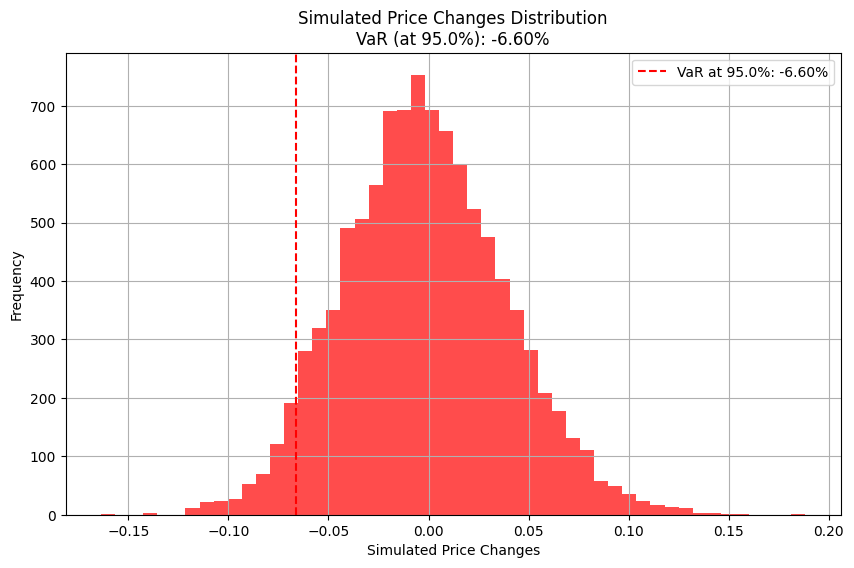

VaR (greatest loss) for META: -6.60%


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004966. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


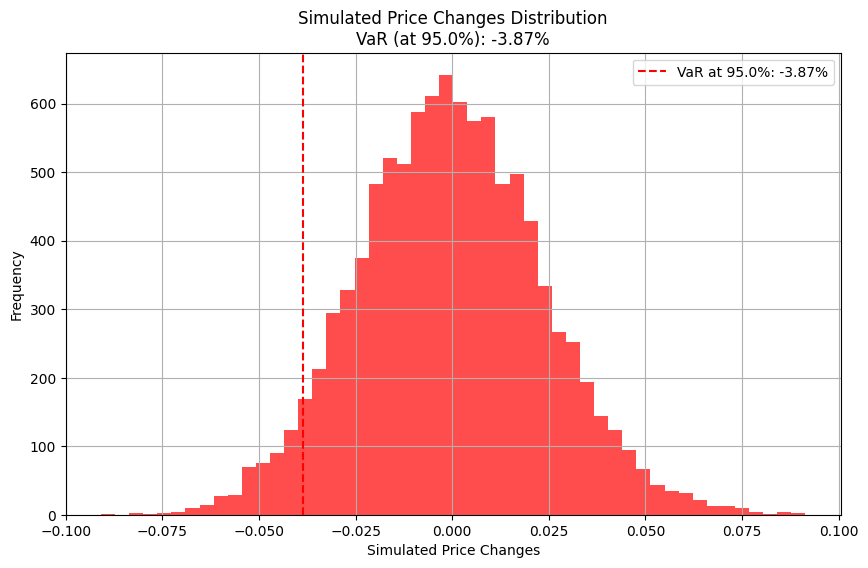

VaR (greatest loss) for MSFT: -3.87%


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001955. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


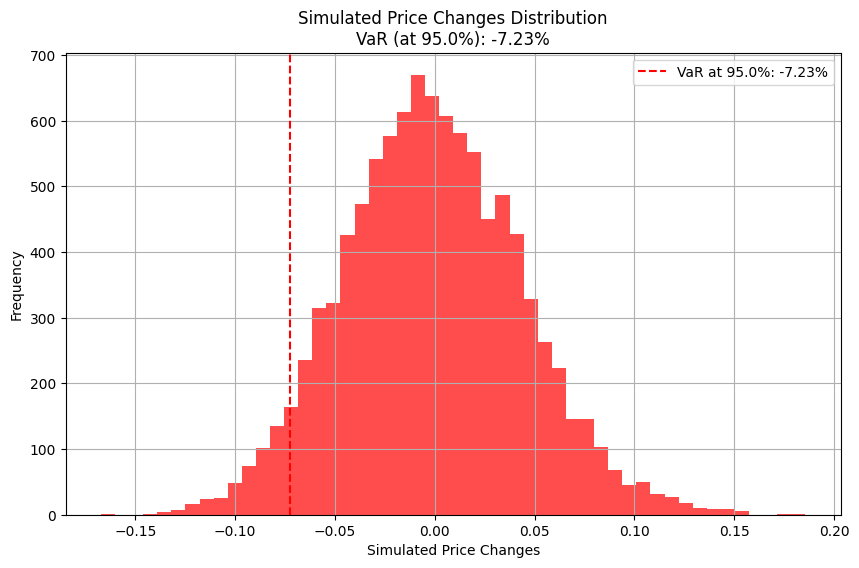

VaR (greatest loss) for NFLX: -7.23%


In [95]:
for name, df in zip(sheet_names, dataframes):
    if not df.empty:
        var = calculate_VaR_MonteCarlo_Normal(df, days=1, iterations=10000, confidence_level=0.95, plot=True)
        print(f"VaR (greatest loss) for {name}: {var*100:.2f}%")

T dis

In [88]:

def calculate_VaR_MonteCarlo_Advanced(df, days=1, iterations=10000, confidence_level=0.99, scale_factor=10, plot=False):
    # Rescaling returns
    returns = df['Close'].pct_change().dropna() * scale_factor

    # GARCH model
    garch = arch_model(returns, vol='Garch', p=1, q=1)
    model = garch.fit(update_freq=10, disp='off')
    forecast = model.forecast(horizon=days)
    vol = np.sqrt(forecast.variance.iloc[-1].iloc[-1]) / scale_factor

    # Fitting t-distribution
    df, loc, scale = t.fit(returns)
    simulated_returns = t.rvs(df, loc, scale, size=(iterations, days))

    # Simulated price changes
    simulated_price_changes = np.exp(simulated_returns * vol) - 1

    # VaR calculation
    VaR = np.percentile(simulated_price_changes, (1 - confidence_level) * 100)

    if plot:
        plt.figure(figsize=(10, 6))
        plt.hist(simulated_price_changes, bins=50, alpha=0.7, color='blue')
        plt.axvline(x=VaR, color='red', linestyle='--', label=f"VaR at {confidence_level*100}%: {VaR*100:.2f}%")
        plt.title(f"Simulated Price Changes Distribution\nVaR (at {confidence_level*100}%): {VaR*100:.2f}%")
        plt.xlabel('Simulated Price Changes')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True)
        plt.show()

    return VaR

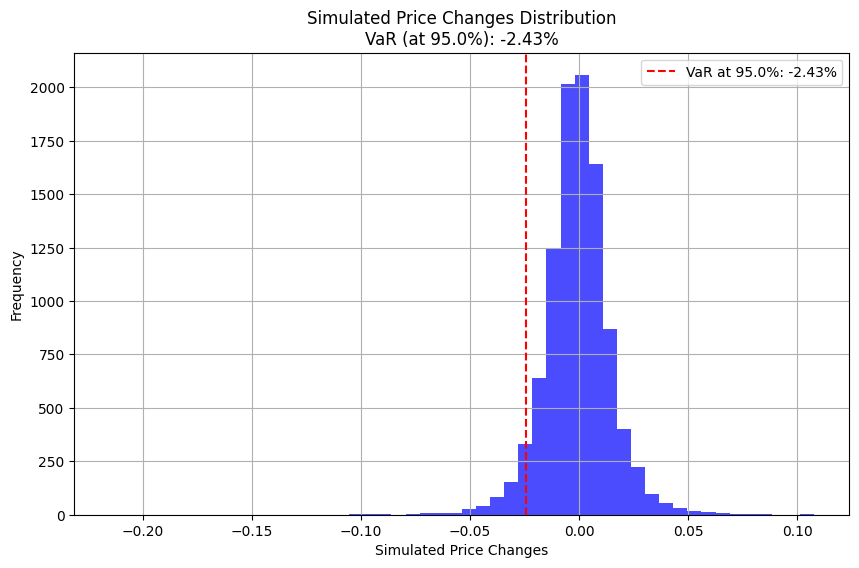

VaR (greatest loss) for META: -2.43%


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04966. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


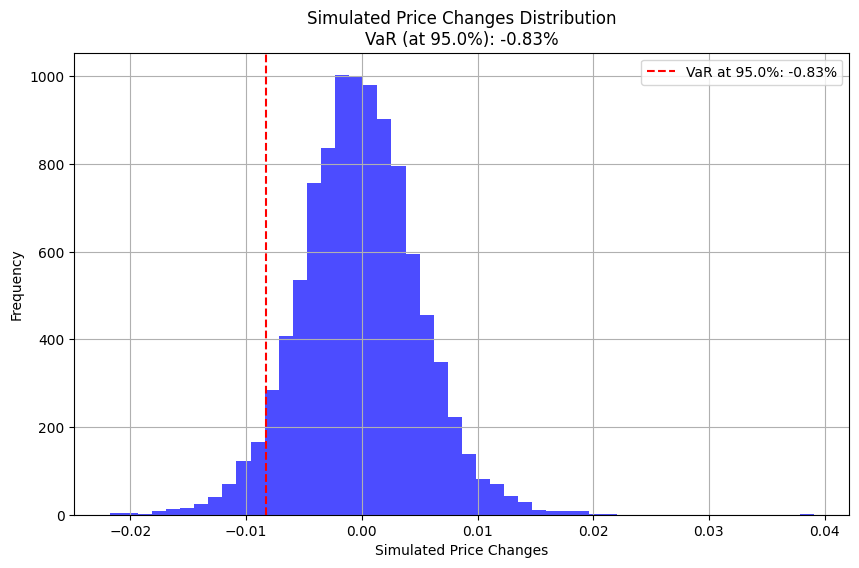

VaR (greatest loss) for MSFT: -0.83%


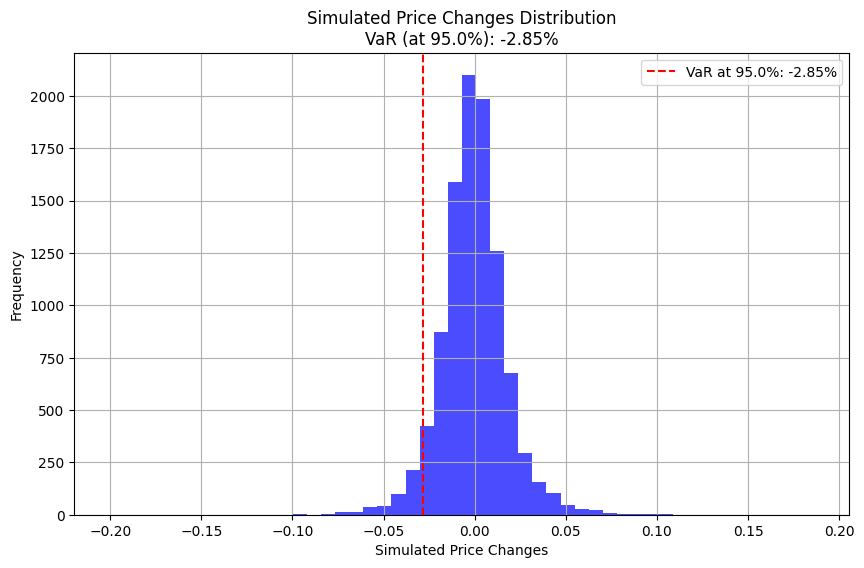

VaR (greatest loss) for NFLX: -2.85%


In [89]:
for name, df in zip(sheet_names, dataframes):
    var = calculate_VaR_MonteCarlo_Advanced(df, days=1, iterations=10000, confidence_level=0.95, plot=True)
    print(f"VaR (greatest loss) for {name}: {var*100:.2f}%")

In [90]:
def plot_monte_carlo_simulation(df, days=252, iterations=1000, confidence_level=0.99):
    # Calculate daily returns
    returns = df['Close'].pct_change().dropna()

    # Fit a GARCH model to estimate volatility
    garch = arch_model(returns, vol='Garch', p=1, q=1)
    model = garch.fit(disp='off')
    forecast = model.forecast(horizon=days)
    vol = np.sqrt(forecast.variance.dropna().mean(axis=0))

    # Fit a t-distribution to returns
    params = t.fit(returns)
    simulated_paths = np.zeros((iterations, days))

    # Simulate paths
    for i in range(iterations):
        daily_simulated_returns = t.rvs(*params[:-2], loc=params[-2], scale=params[-1], size=days) * vol
        simulated_paths[i, :] = np.cumprod(1 + daily_simulated_returns) * df['Close'].iloc[-1]

    # Plot simulations
    colors = cm.rainbow(np.linspace(0, 1, iterations))
    plt.figure(figsize=(10, 6))
    for i in range(iterations):
        plt.plot(simulated_paths[i], color=colors[i], alpha=0.2)  # Adjust alpha as needed

    plt.title(f"Monte Carlo Simulation ({iterations} simulations)")
    plt.xlabel('Days')
    plt.ylabel('Simulated Price')
    plt.grid(True)
    plt.show()

Plotting Monte Carlo simulations for META


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001645. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


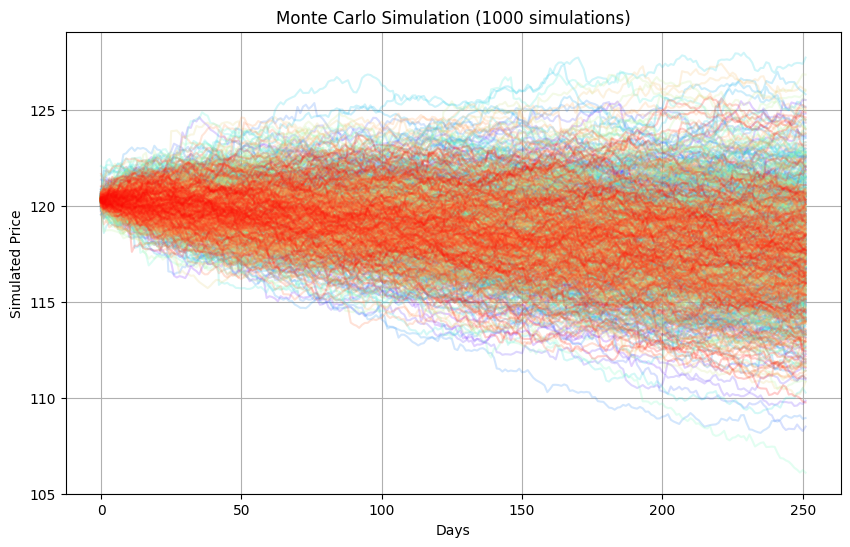

Plotting Monte Carlo simulations for MSFT


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004966. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


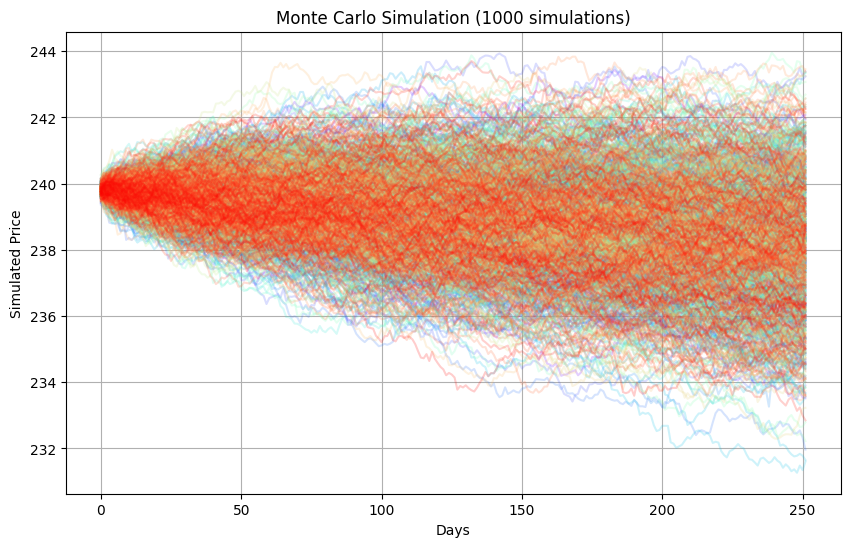

Plotting Monte Carlo simulations for NFLX


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001955. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


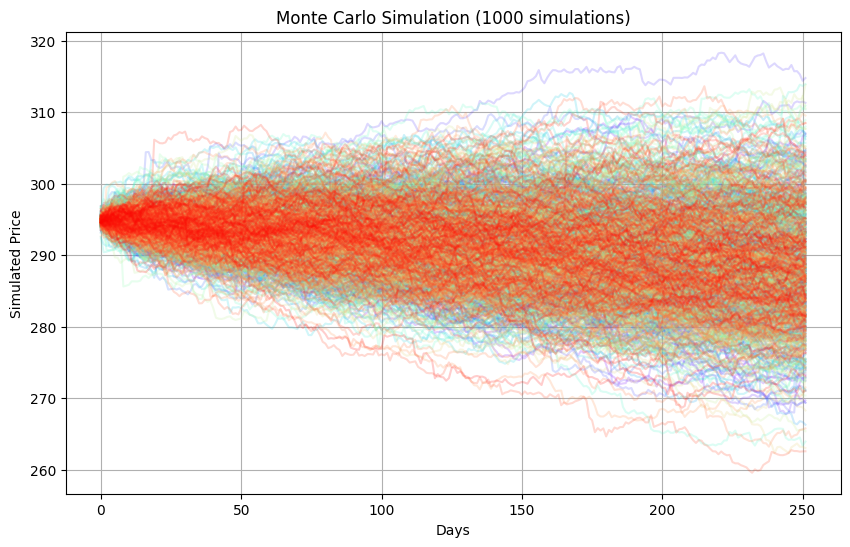

In [91]:
for name, df in zip(sheet_names, dataframes):
    if not df.empty:
        print(f"Plotting Monte Carlo simulations for {name}")
        plot_monte_carlo_simulation(df)

Portfolio

In [ ]:
initial = 100

ML

OPtimize / Tuning Parameters